In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
%matplotlib inline

# Data collection

## Load data

Load daily food log

In [2]:
food = pd.read_csv('food.csv', parse_dates=['date'])
food.head()

,date,name,type,quantity,units,calories,fat,protein,carb,saturated_fat,sugar,fiber,cholesterol,sodium
0,2018-08-29,"Egg, Fried, Large",Breakfast,50.0,Grams,98,7.66,6.81,0.45,2.15,0.42,0.00,228.50,102.0
1,2018-08-29,"Fish Ball, Asian Style, Cooked",Breakfast,153.0,Grams,116,1.22,18.82,6.88,0.31,2.14,0.00,110.16,994.5
2,2018-08-29,"Green Beans, Cooked",Breakfast,50.0,Grams,18,0.14,0.95,3.94,0.30,1.82,1.60,0.00,0.5
3,2018-08-29,"Soup, Egg Drop, Restaurant",Breakfast,3.0,Cups,195,4.41,8.39,31.20,1.16,0.65,2.89,166.29,2675.1
4,2018-08-29,"Egg, Fried, Large",Lunch,50.0,Grams,98,7.66,6.81,0.45,2.15,0.42,0.00,228.50,102.0


Load daily calories budget, steps, and logged weights

In [3]:
budget = pd.read_csv('budget.csv', parse_dates=['date'], index_col=0, squeeze=True)
steps = pd.read_csv('steps.csv', parse_dates=['date'], index_col=0, squeeze=True)
weights = pd.read_csv('weights.csv', parse_dates=['date'], index_col=0)

## Data transformation

Aggregate calories from food eaten during each day to get total calories consumed for that day

In [4]:
daily_cal = food.groupby('date')['calories'].sum()

For each day, find weight of the following day and record the weight gain from one day to the next (negative weight gain = weight loss)

In [5]:
weights['tomorrow_weight'] = weights.reindex(weights.index + pd.Timedelta(1, unit='D')).values
weights['weight_gain'] = weights['tomorrow_weight'] - weights['weight']

Merge daily calories consumed, budget calories, steps, and weight together, dropping rows with missing values

In [6]:
df = pd.concat([daily_cal, budget, steps, weights], axis=1).dropna()

Calculate daily calories surplus (calories consumed beyond budget)

In [7]:
df['surplus'] = df['calories'] - df['budget']

# Exploratory Data Analysis

## Plots

Weights tend to fluctuate but shows general decrease during this time period

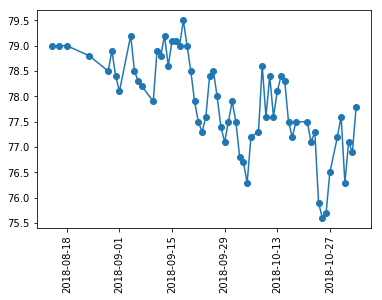

In [8]:
plt.plot(weights.index, weights['weight'].values, marker='o')
plt.xticks(rotation=90)
plt.show()

Among dates where the weight of the next date was recorded, 41.5% of them ended up in weight gain, 56.5% in weight loss, and the rest where weight did not change.

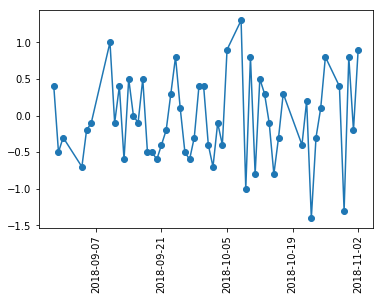

In [145]:
plt.plot(weights['weight_gain'].dropna().index, weights['weight_gain'].dropna().values, marker='o')
plt.xticks(rotation=90)
plt.show()

In [12]:
(weights['weight_gain'].dropna() > 0).mean(), (weights['weight_gain'].dropna() < 0).mean()

(0.41509433962264153, 0.5660377358490566)

However, among dates where relevant features (steps and calories consumed) are recorded, the proportion of dates with weight gain drops to 39%. This is not a huge class imbalance and so class imbalance treatments will not be used in this project.

In [23]:
(df['weight_gain'] > 0).mean()

0.391304347826087

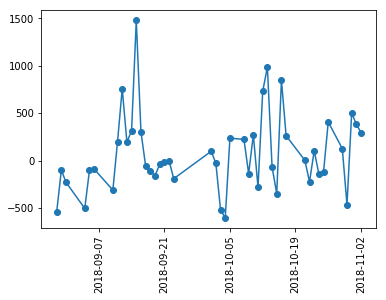

In [13]:
plt.plot(df.index, df['surplus'], marker='o')
plt.xticks(rotation=90)
plt.show()

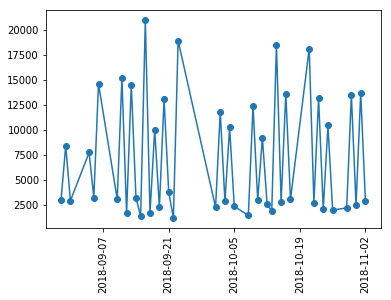

In [157]:
plt.plot(df.index, df['step'], marker='o')
plt.xticks(rotation=90)
plt.show()

Relationship between calories surplus and weight gain

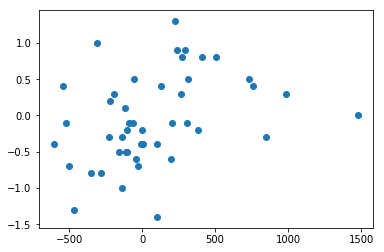

In [16]:
plt.scatter(df['surplus'], df['weight_gain'])
plt.show()

Relationship between steps and weight gain

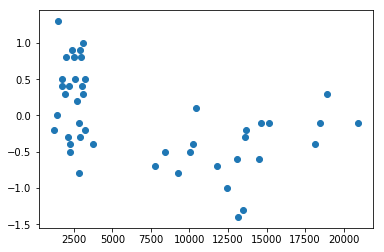

In [17]:
plt.scatter(df['step'], df['weight_gain'])
plt.show()

Plot weight gain status against 2-D representation of (calories surplus, steps)

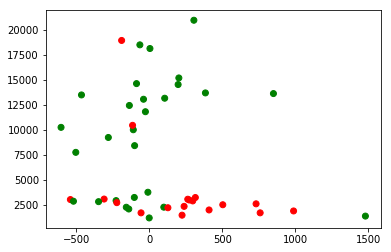

In [18]:
plt.scatter(df['surplus'], df['step'], color=list(np.where(df['weight_gain'] > 0, 'Red', 'Green')))
plt.show()

# Logistic Regression